## Patient Hub: Azure Machine Learning in Medical Industry

# Patient Hub - High Level Architecture
Train a base model to use for all patients, but then customize and redeploy without requiring machine learning knowledge

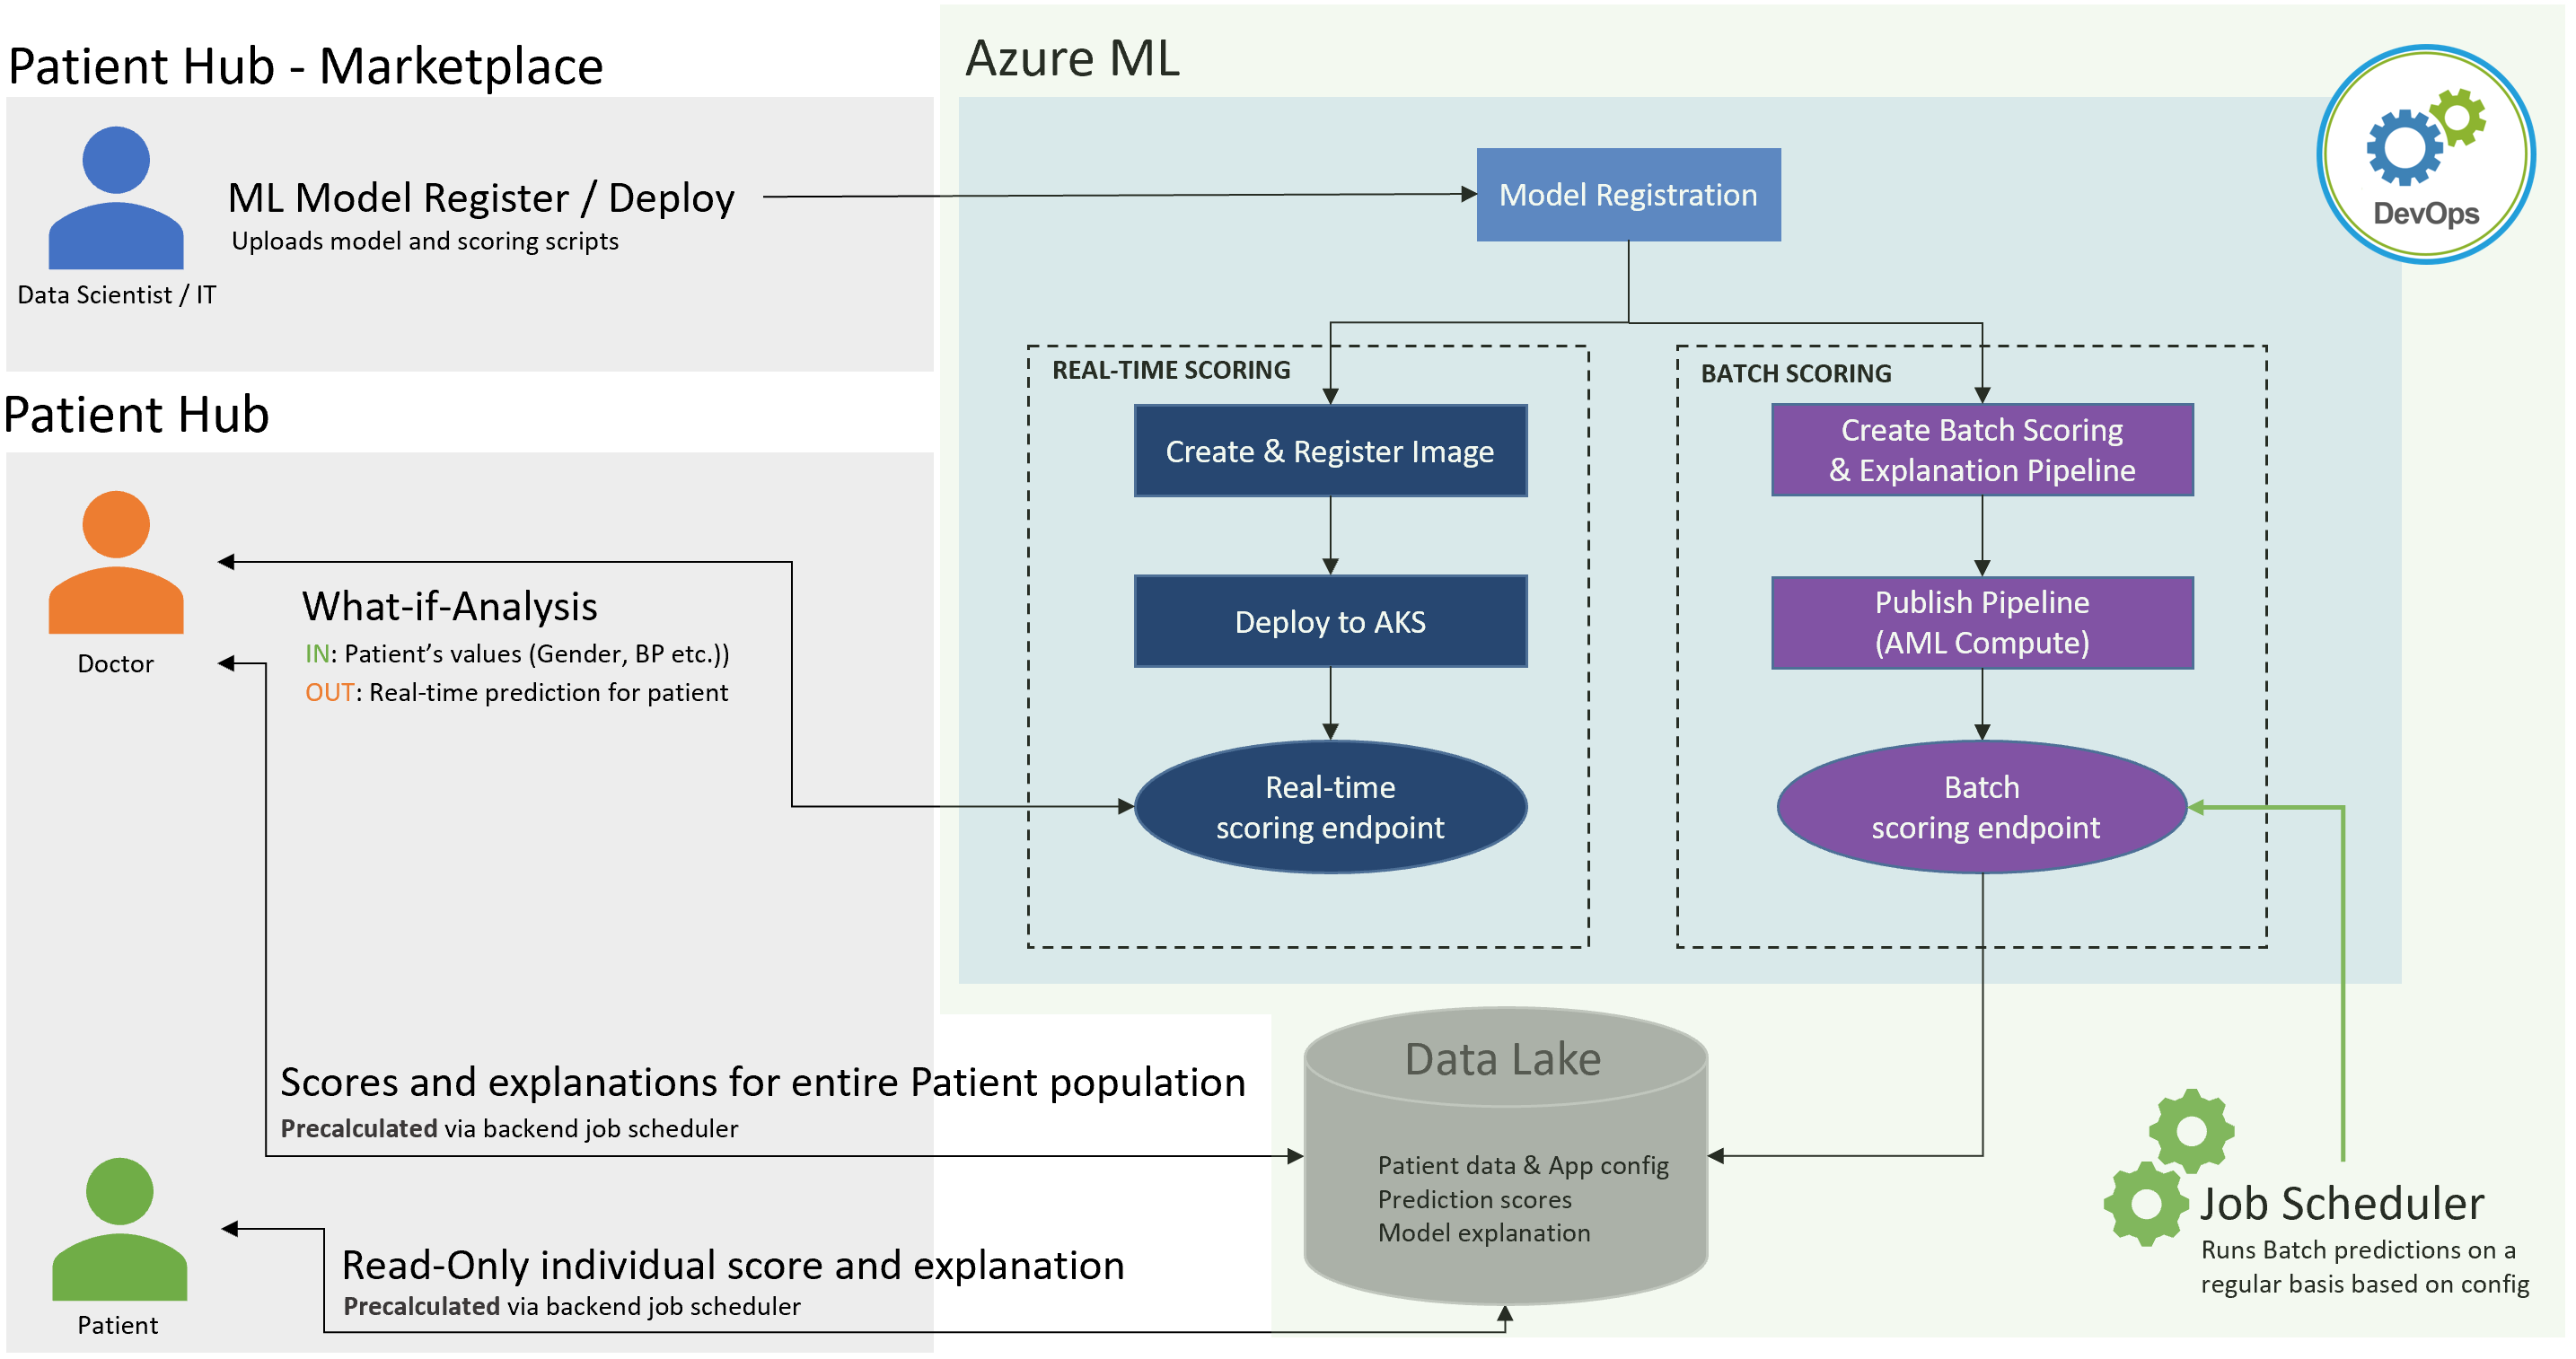

## Patient View
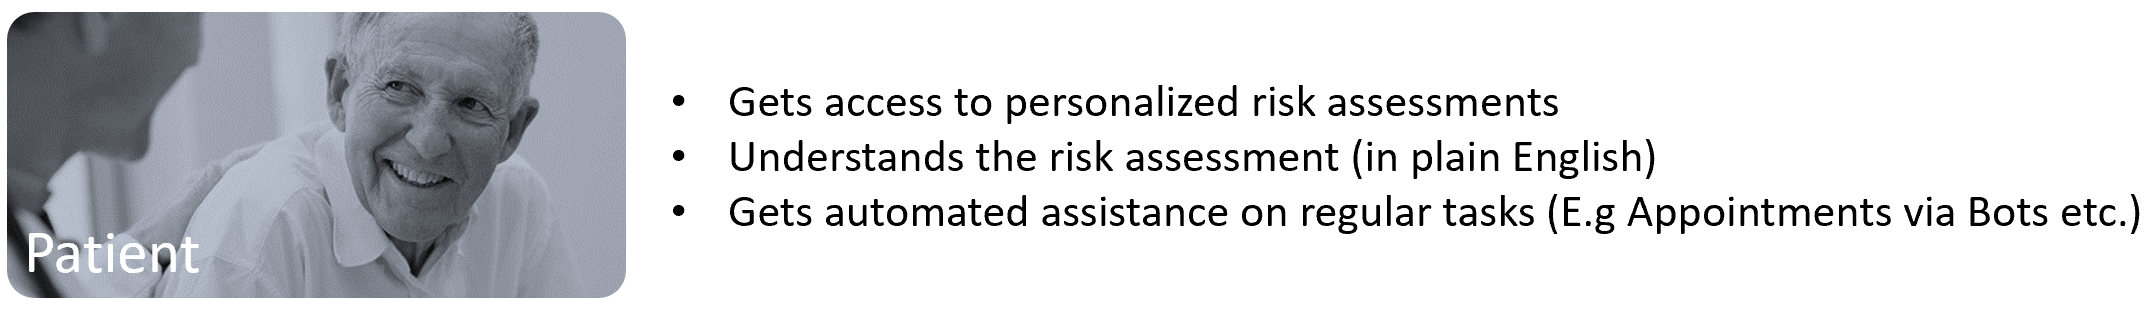

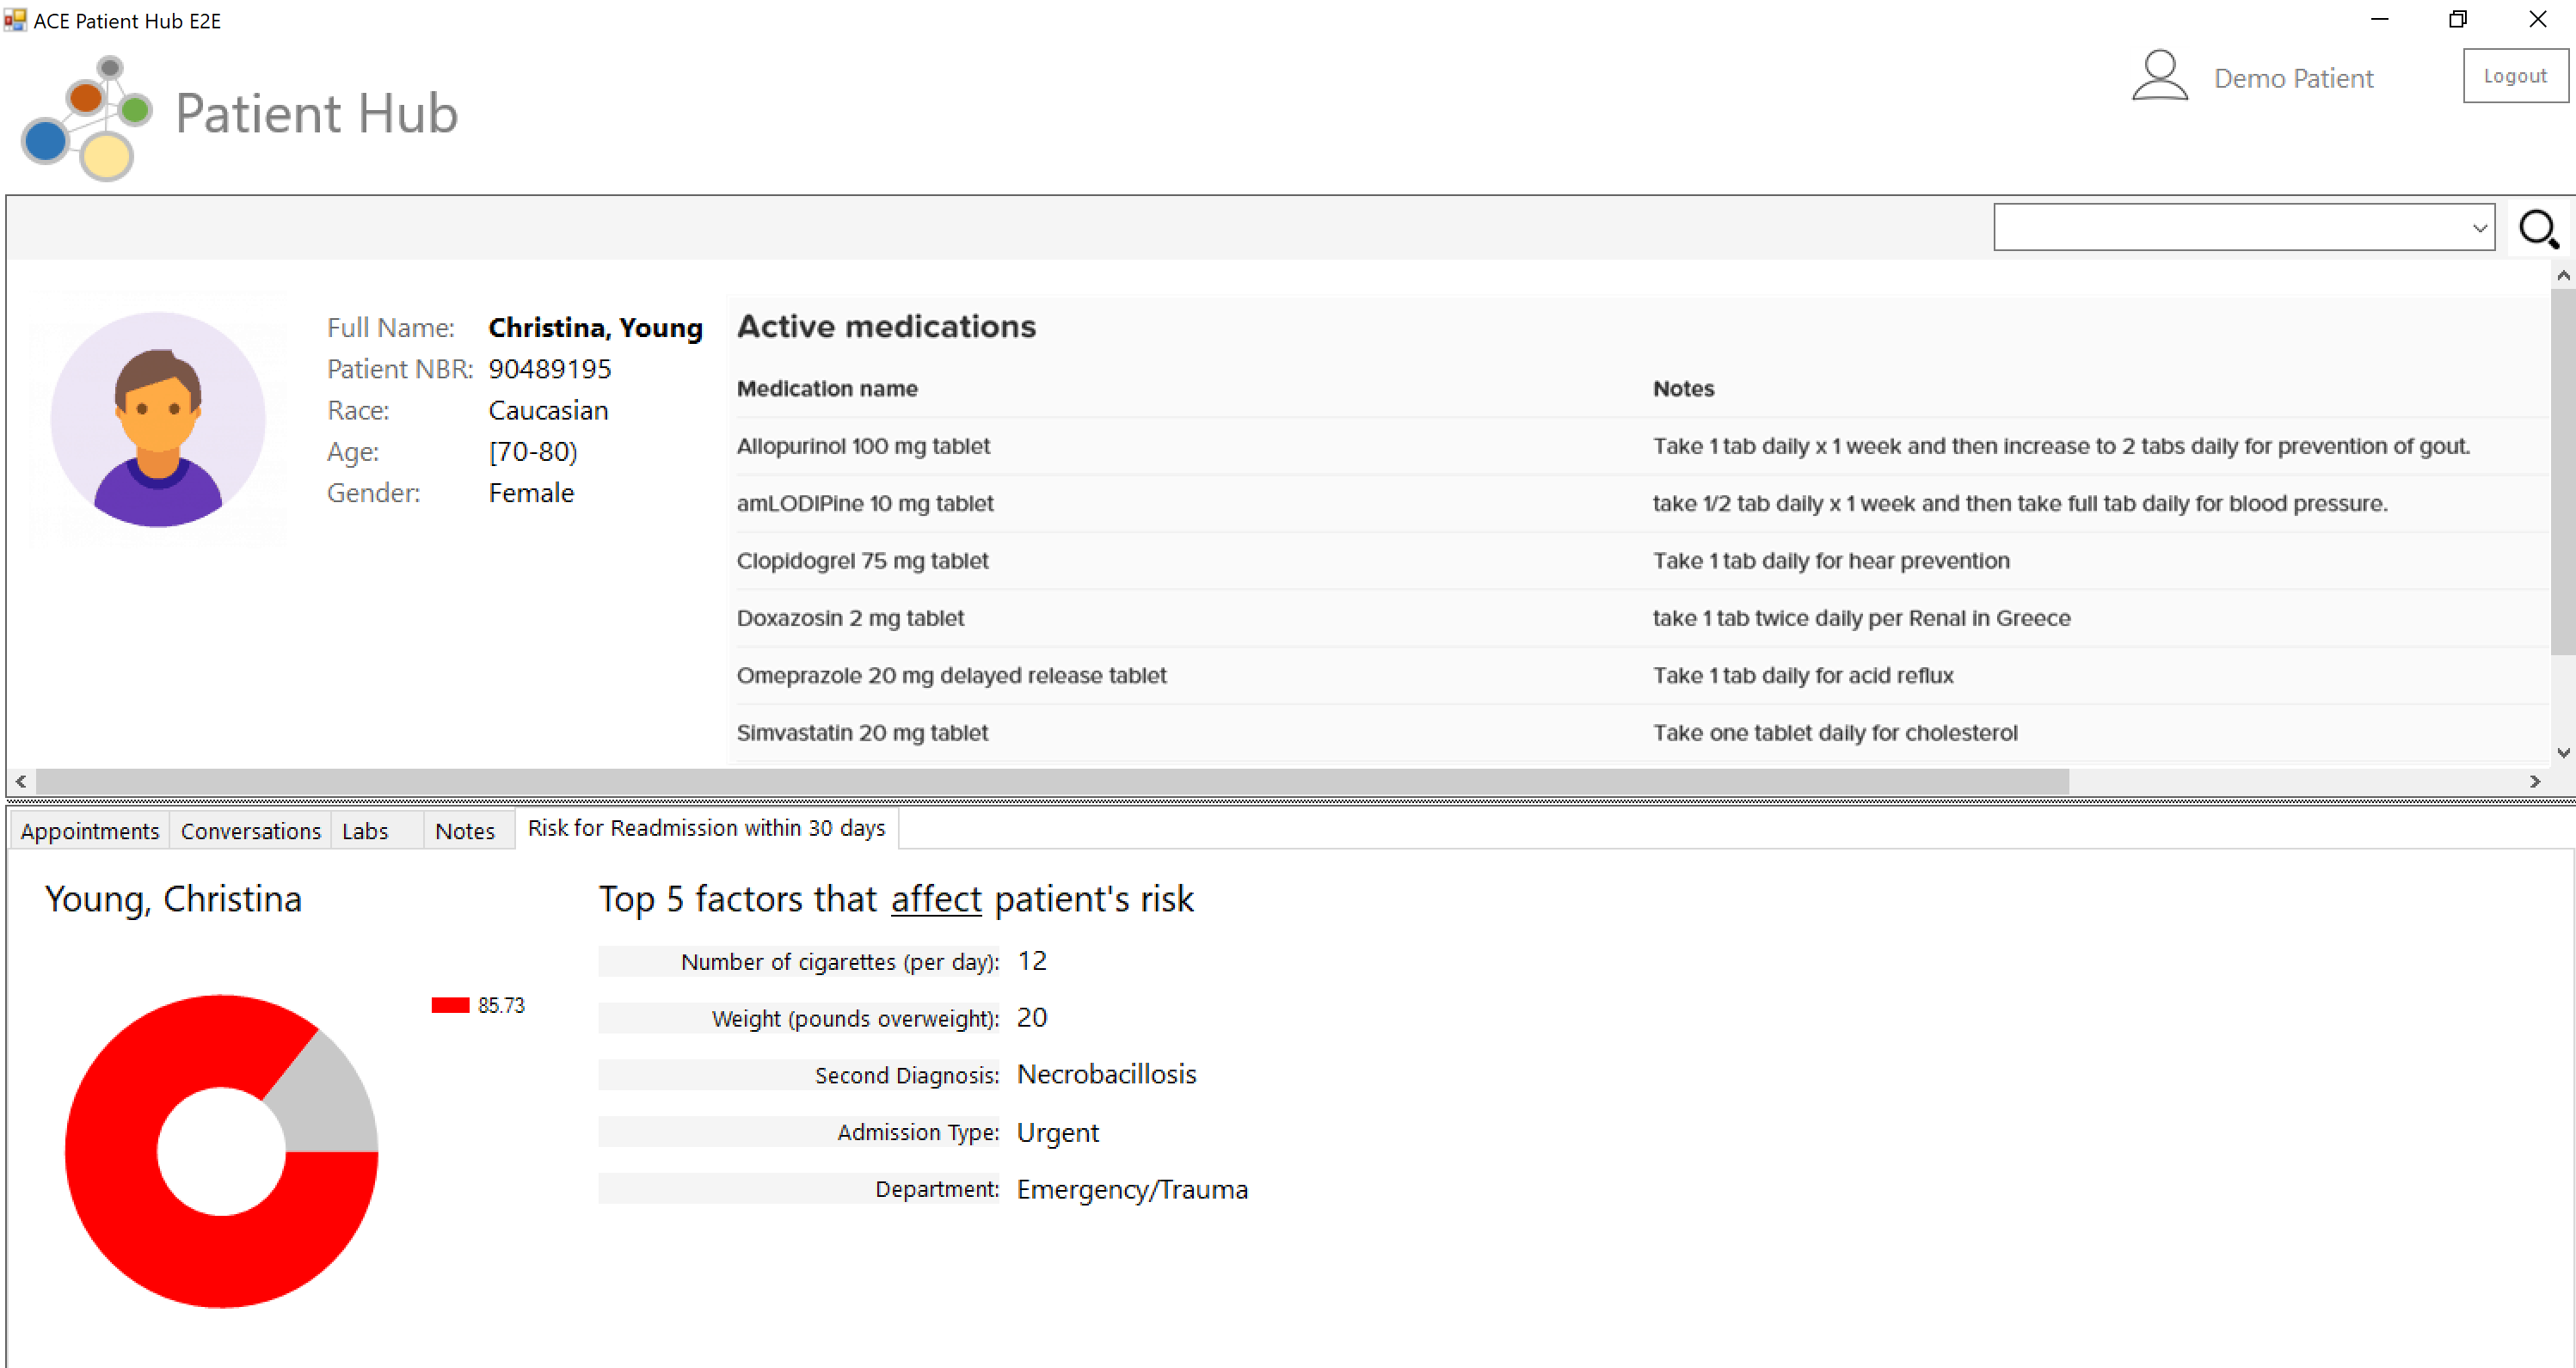

## Doctor View
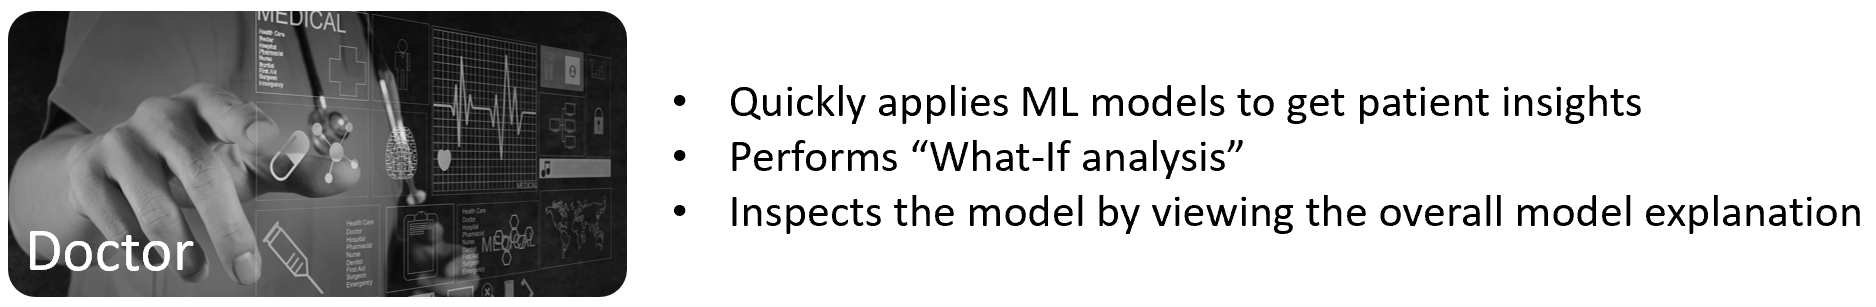

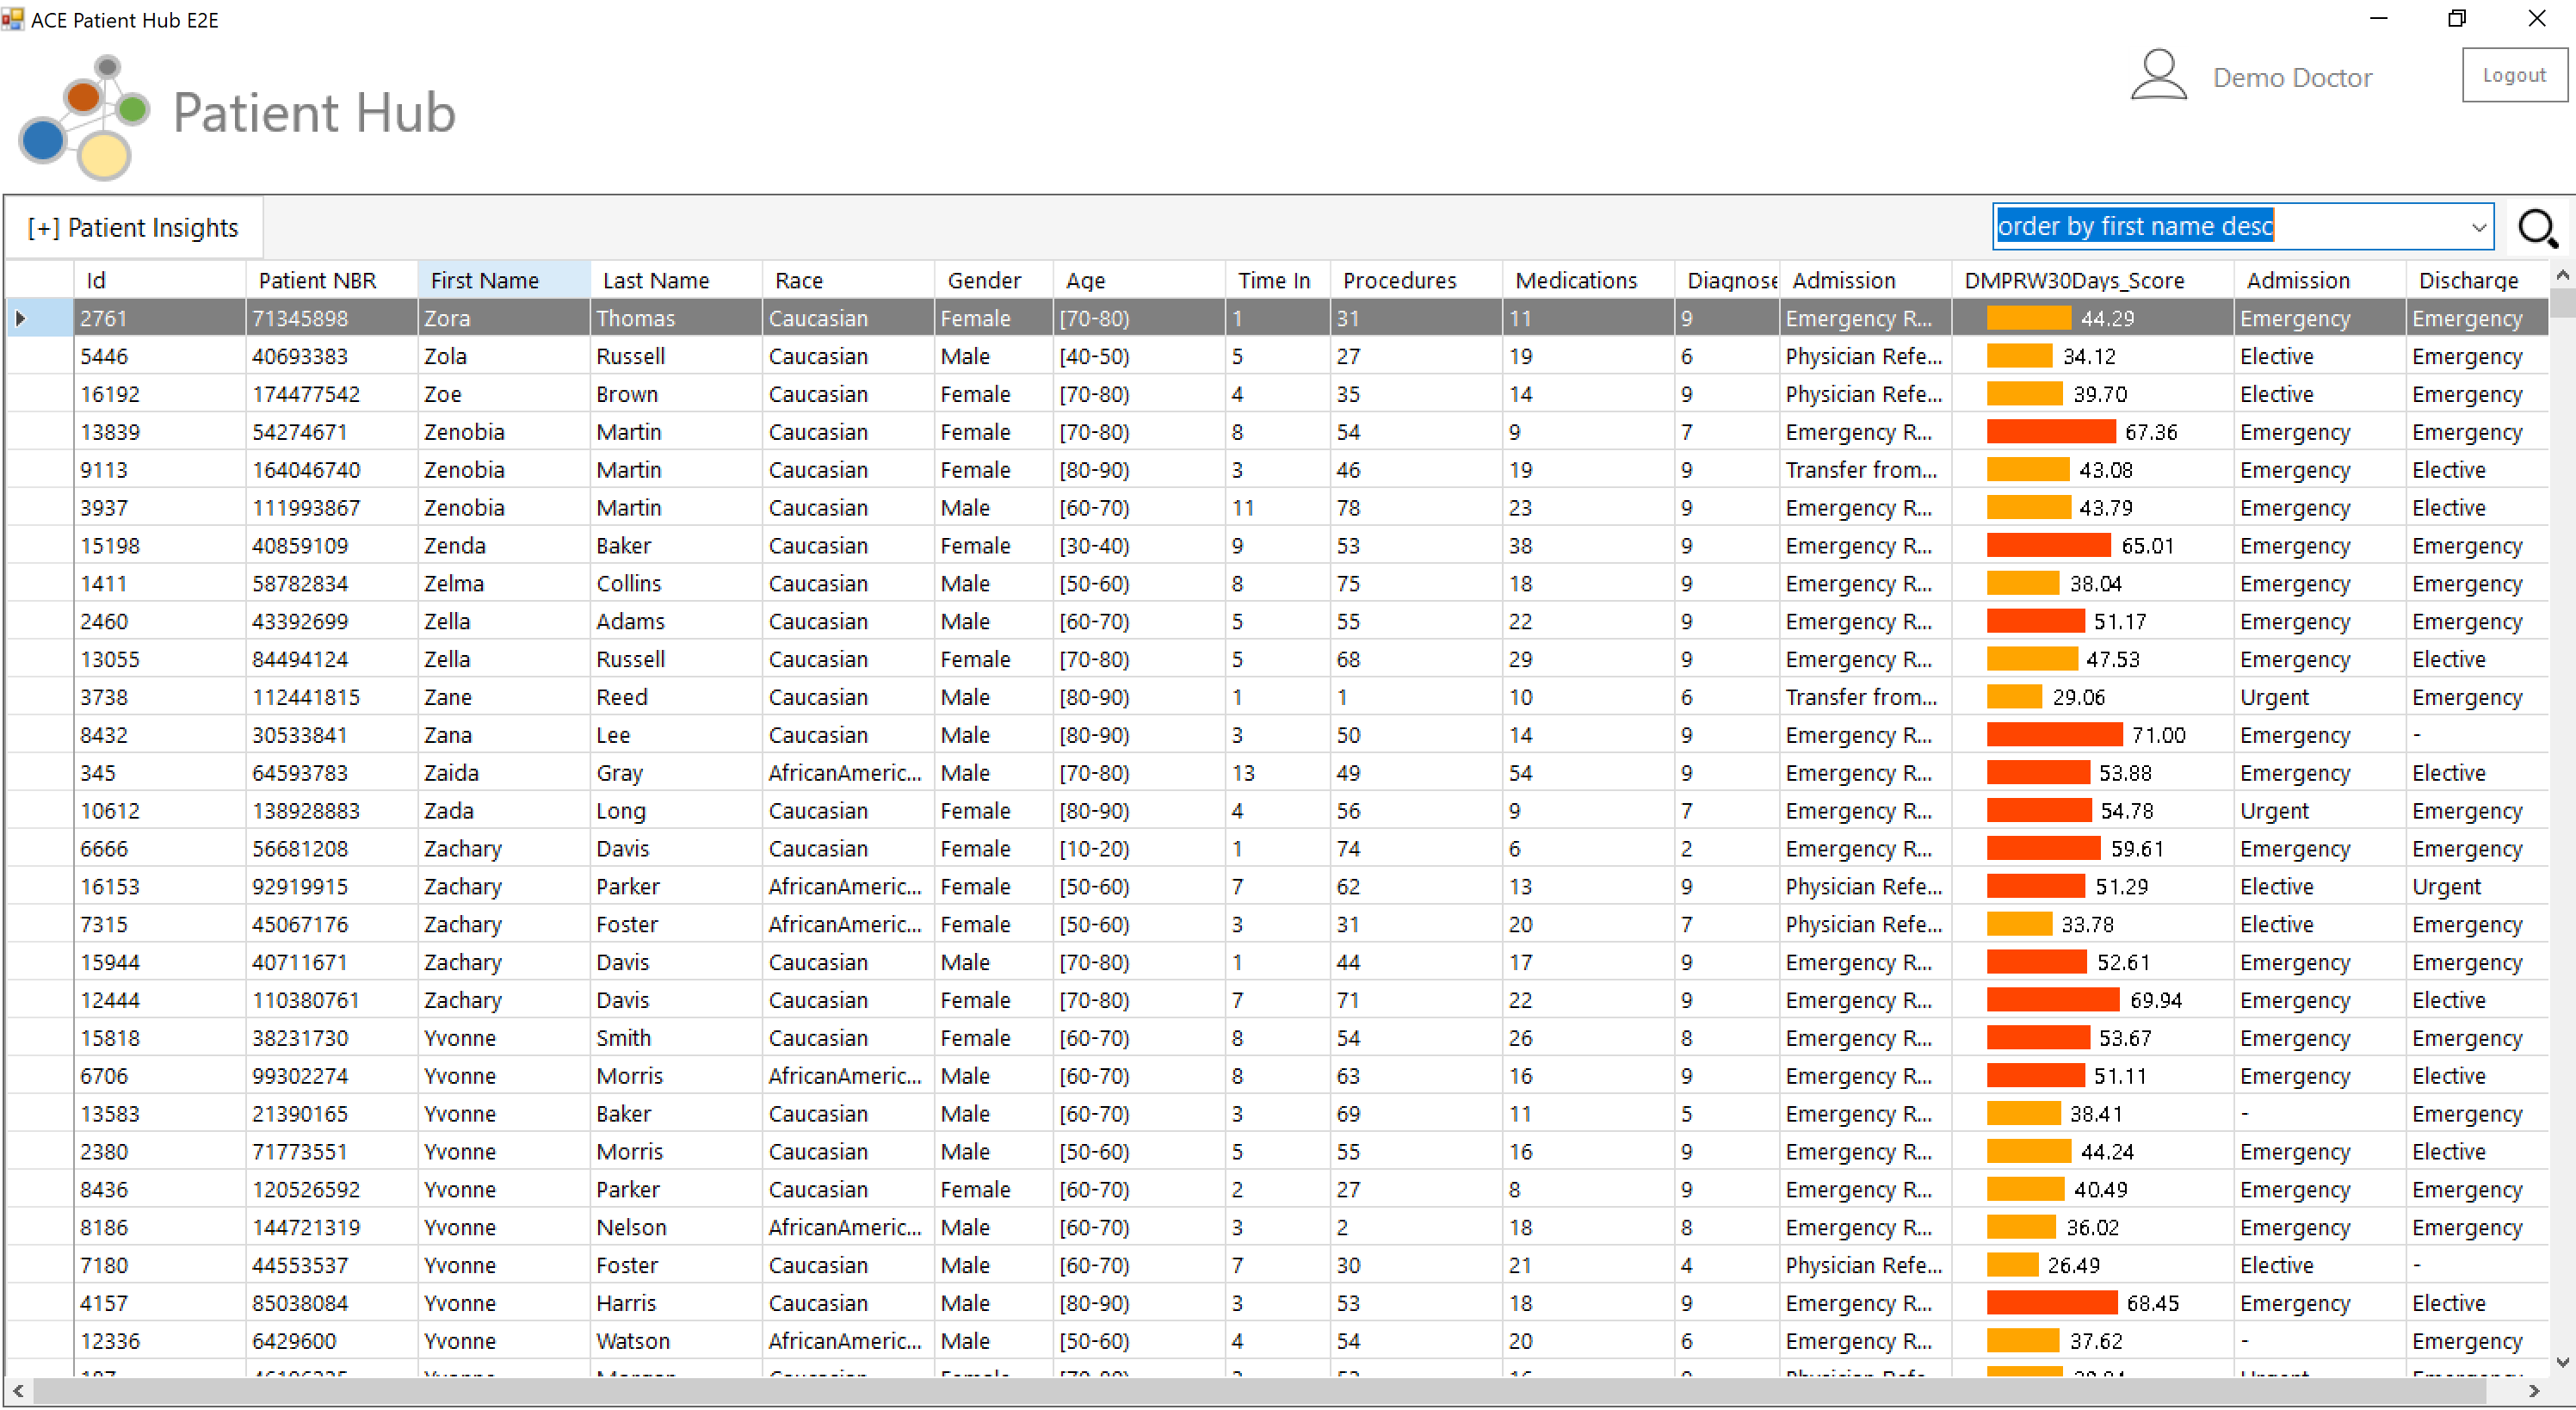
1. Most EMR history data is static, so it’s quite common to do batch scoring on a nightly basis.
2. Pre-generating prediction speeds up UX and saves infra cost (from repeating the same prediction).  
3. Model explanation can often be very time-consuming, hence needs to be executed as batch process.

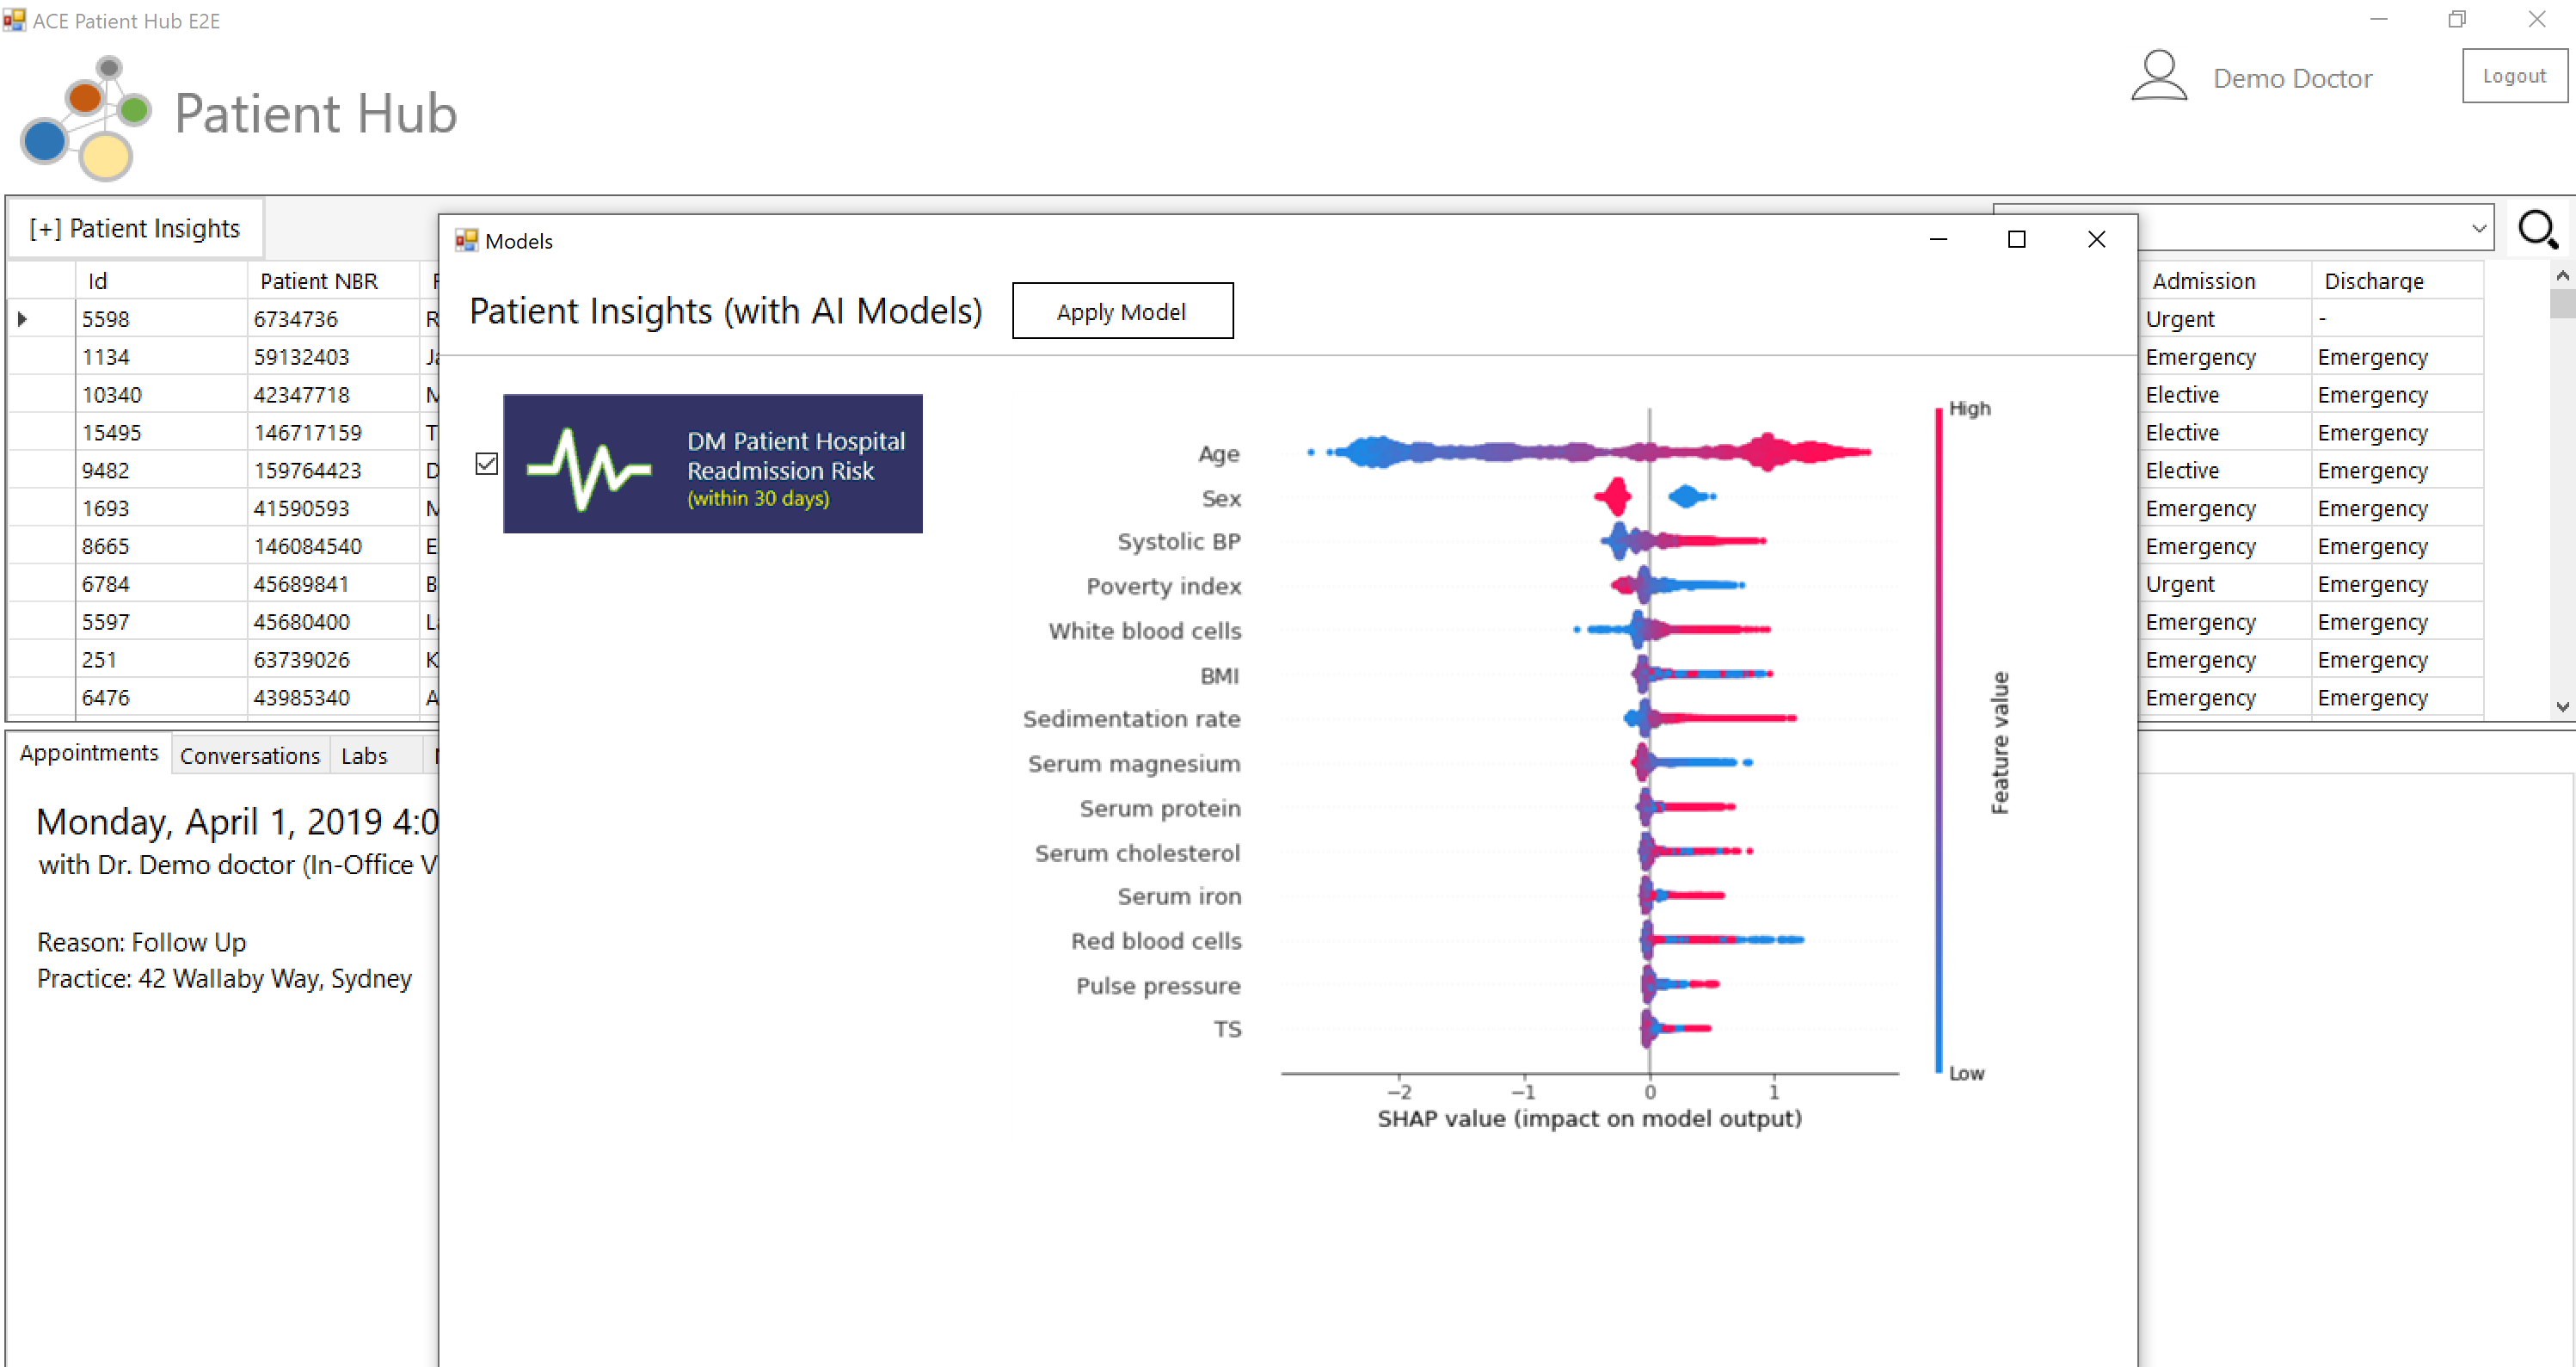
Model Interpretation 

## Data Scientist/IT View
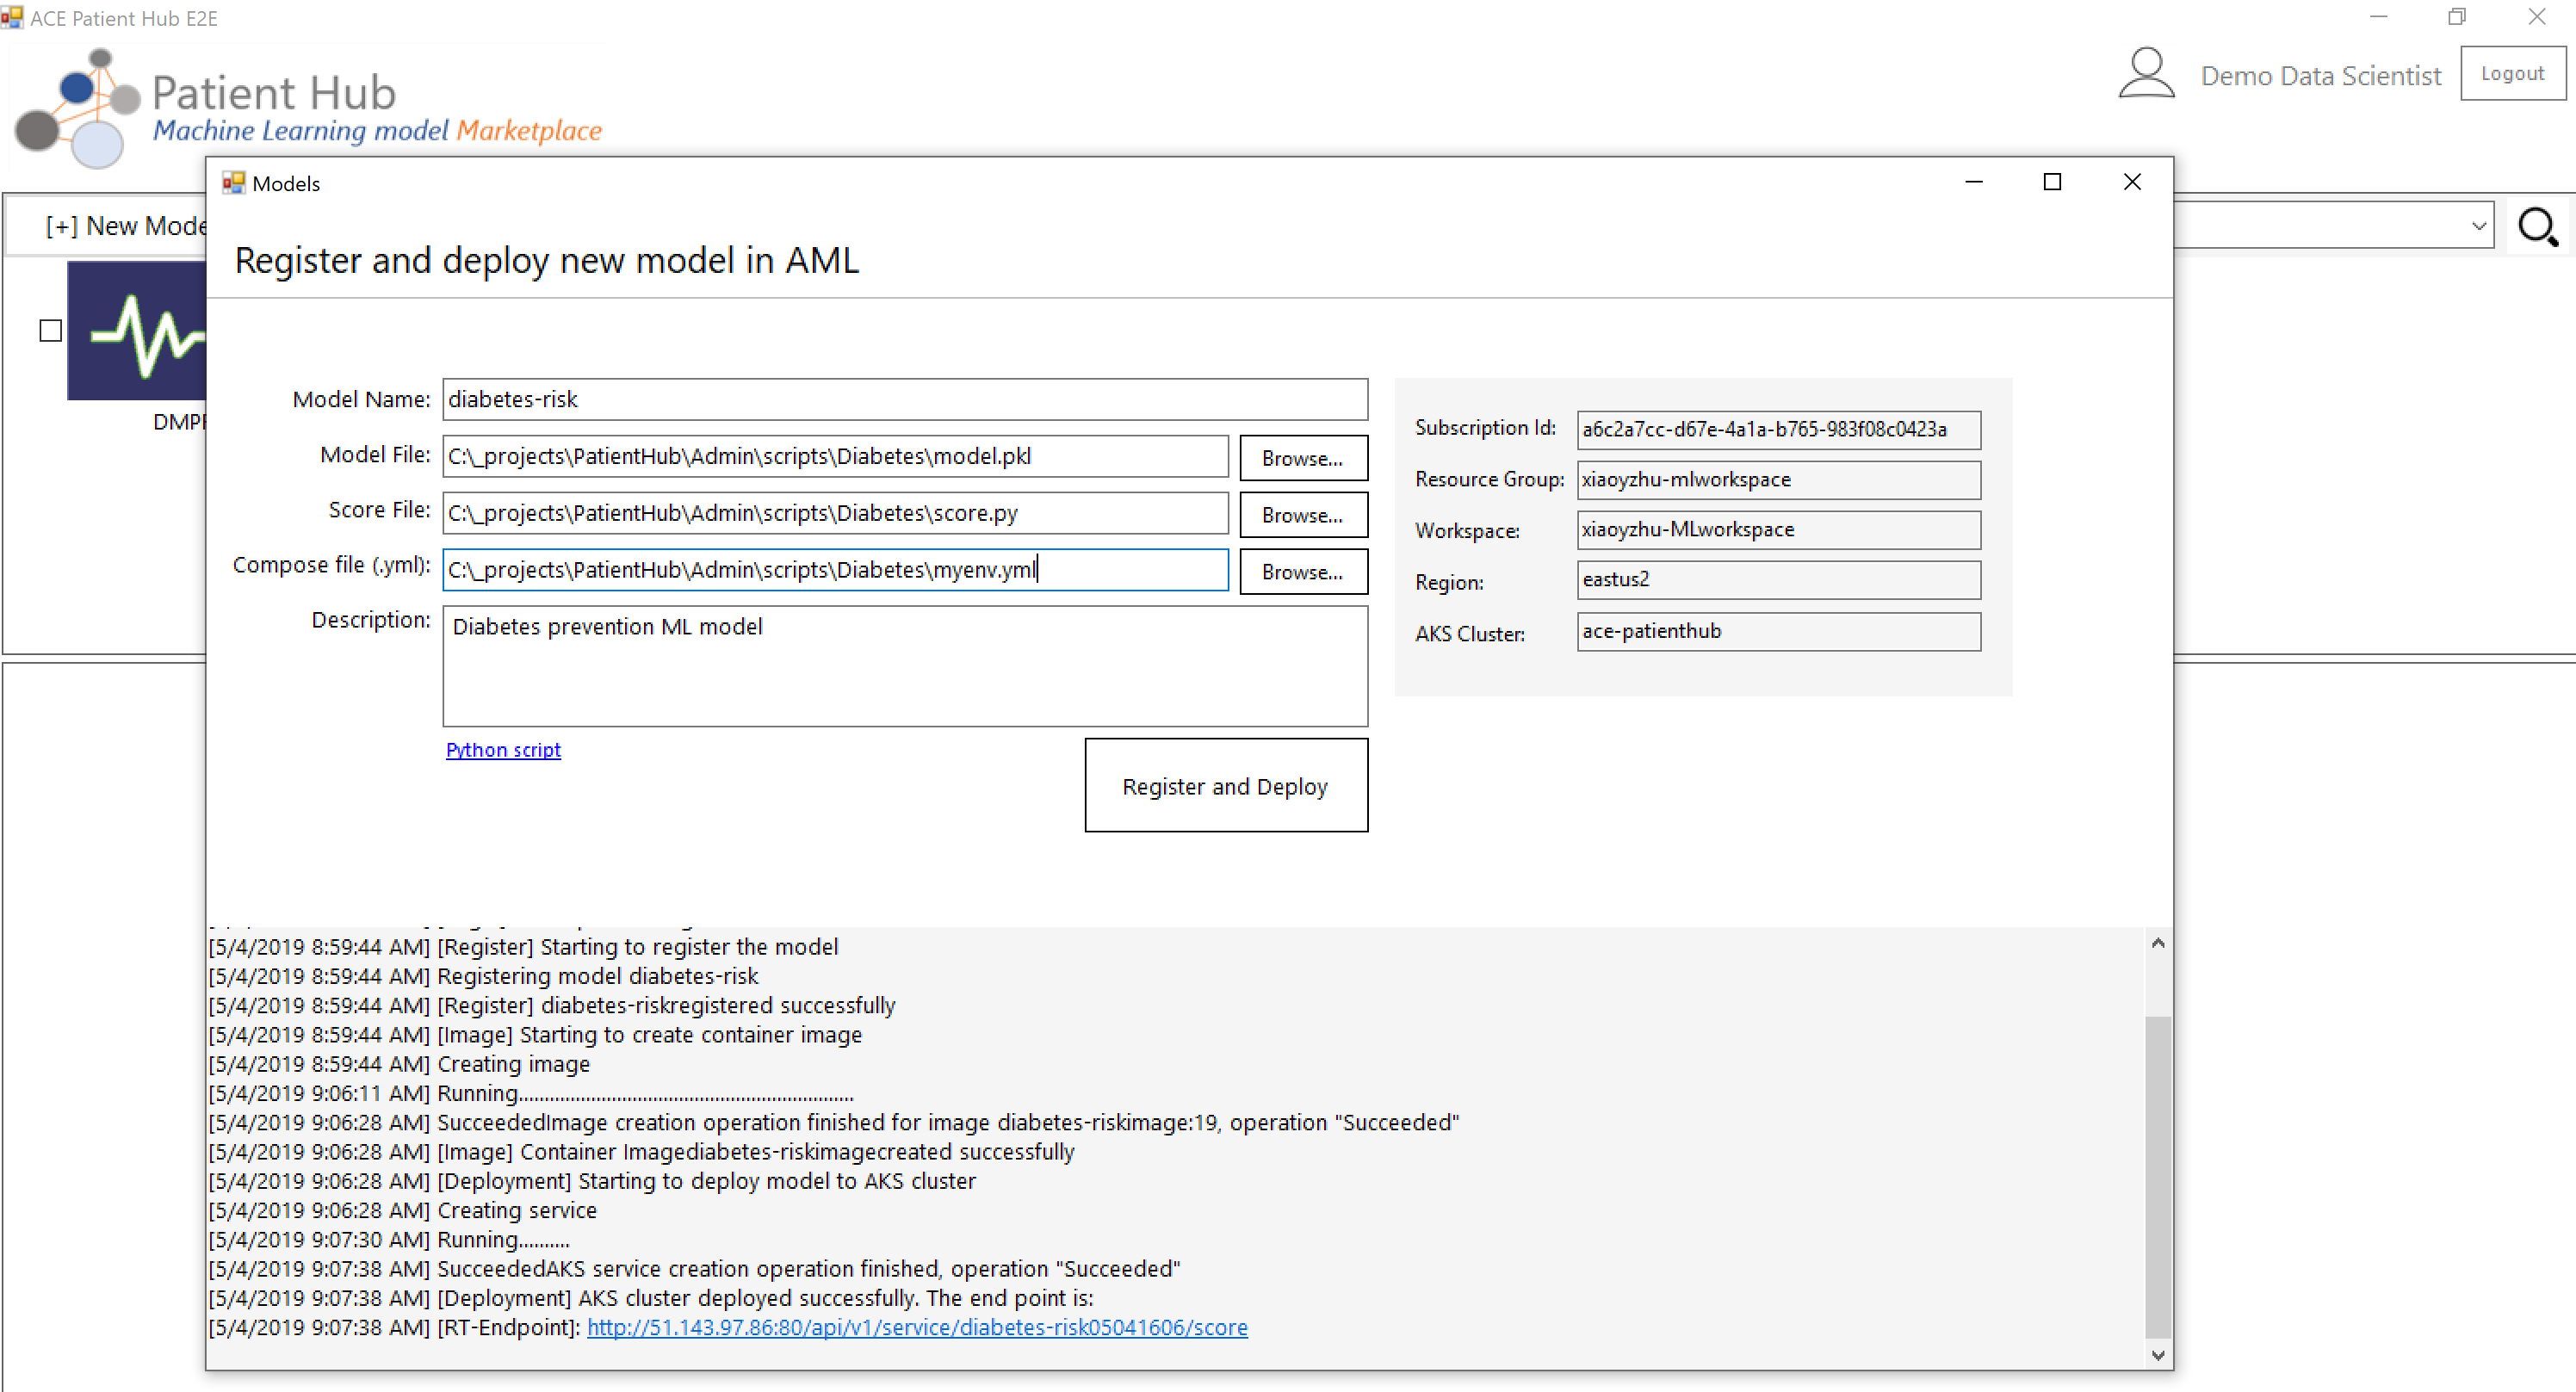

## Deploying the model using Azure Machine Learning
This runs behind the scenes using the Azure Machine Learning Python SDK to deploy the new models

In [1]:
# import argparse
import os
from time import gmtime, strftime

import azureml.core
import numpy as np
from azureml.core import Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.experiment import Experiment
from azureml.core.image import ContainerImage, Image
from azureml.core.model import Model
from azureml.core.webservice import AksWebservice, Webservice
from azureml.telemetry import set_diagnostics_collection

In [ ]:
# Read input 
parser = argparse.ArgumentParser(description='Process some integers.')
parser.add_argument('--script_file_name', dest='script_file_name', required=True)
parser.add_argument('--conda_env_file_name', dest='conda_env_file_name', required=True)
parser.add_argument('--default_subscription_id', dest='default_subscription_id', required=True)
parser.add_argument('--default_resource_group', dest='default_resource_group', required=True)
parser.add_argument('--default_workspace_name', dest='default_workspace_name', required=True)
parser.add_argument('--default_workspace_region', dest='default_workspace_region', required=True)
parser.add_argument('--model_path', dest='model_path', required=True)
parser.add_argument('--model_name', dest='model_name', required=True)
parser.add_argument('--model_description', dest='model_description', required=True)
parser.add_argument('--aks_cluster_name', dest='aks_cluster_name', required=True)
args = parser.parse_args()

subscription_id = os.getenv("SUBSCRIPTION_ID", default=default_subscription_id)
resource_group = os.getenv("RESOURCE_GROUP", default=default_resource_group)
workspace_name = os.getenv("WORKSPACE_NAME", default=default_workspace_name)
workspace_region = os.getenv("WORKSPACE_REGION", default=default_workspace_region)

In [ ]:
# Login to the ML Workspace

try:
    ws = Workspace(subscription_id=subscription_id,
                   resource_group=resource_group, workspace_name=workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config(file_name="config.json")
    print("[Login] Workspace configuration succeeded.")
except:
    print("[ERROR] Workspace not accessible.")

## Register the new model for auditability and lineage

In [ ]:
# Register the model for deployment

print("[Register] Starting to register the model")

# Register the model

model = Model.register(model_path=model_path,  # this points to a local file
                       model_name=model_name,  # this is the name the model is registered as
                       tags={'area': "diabetes", 'type': "regression"},
                       description=model_description,
                       workspace=ws)

# print(model.name, model.description, model.version)
print("[Register] " + model.name + "registered successfully")

In [ ]:
# Create container image

print("[Image] Starting to create container image")
image_config = ContainerImage.image_configuration(runtime="python",
                                                  execution_script=script_file_name,
                                                  conda_file=conda_env_file_name,
                                                  tags={
                                                      'area': "digits", 'type': "automl_classification"},
                                                  description=model_description)

image = Image.create(name=model_name+"image",
                     # this is the model object
                     models=[model],
                     image_config=image_config,
                     workspace=ws)

image.wait_for_creation(show_output=True)

if image.creation_state == 'Failed':
    print("[ERROR] Image build log at: " + image.image_build_log_uri)
print("[Image] Container Image" + model_name+"image" + "created successfully")

## Deploy to Azure Kubernetes Service using Azure Machine Learning

In [ ]:
# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration()

print("[Deployment] Starting to deploy model to AKS cluster")
# Create the cluster
aks_target = ComputeTarget.create(workspace=ws,
                                  name=aks_name,
                                  provisioning_configuration=prov_config)


In [ ]:
# Deploy to AKS Cluster
aks_service_name = model_name+strftime("%m%d%H%M", gmtime())

aks_service = Webservice.deploy_from_image(workspace=ws,
                                           name=aks_service_name,
                                           image=image,
                                           deployment_config=aks_config,
                                           deployment_target=aks_target)
aks_service.wait_for_deployment(show_output=True)

services = Webservice.list(ws)
print("[Deployment] AKS cluster deployed successfully. The end point is: ")
print("[RT-Endpoint]: " + services[0].scoring_uri)

## How we trained the original model with Azure Machine Learning

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from azureml.telemetry import set_diagnostics_collection
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
import sklearn.metrics 
from azureml.core.experiment import Experiment
import matplotlib.pyplot as plt

import multiprocessing
import numpy as np

### kaggle
datain_dir = './'
datain_col_dir = './'
dataout_dir = ''